In [1]:
library(Seurat)
library(ggplot2)
library(enrichR)
library(stringr)
library(RColorBrewer)
library(pheatmap)
library(dplyr)
library(tibble)

Warning message:
“package ‘Seurat’ was built under R version 4.3.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.3.3”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.3.3”

Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is Live!

WormEnrichr ... 
Connection is Live!

YeastEnrichr ... 
Connection is Live!

FishEnrichr ... 
Connection is Live!

OxEnrichr ... 
Connection is Live!

Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from

In [2]:
packageVersion("Seurat")
packageVersion("SeuratObject")
packageVersion("Matrix")

[1] ‘5.1.0’

[1] ‘5.0.2’

[1] ‘1.6.5’

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11332
Number of edges: 631561

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8353
Number of communities: 11
Elapsed time: 2 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:09:30 UMAP embedding parameters a = 0.9922 b = 1.112

14:09:30 Read 11332 rows and found 30 numeric columns

14:09:30 Using Annoy for neighbor search, n_neighbors = 30

14:09:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:09:35 Writing NN index file to temp file /tmp/Rtmp4nelDF/file1d99574a3a7c2e

14:09:35 Searching Annoy index using 1 thread, search_k = 3000

14:09:39 Annoy recall = 64.28%

14:09:39 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighb

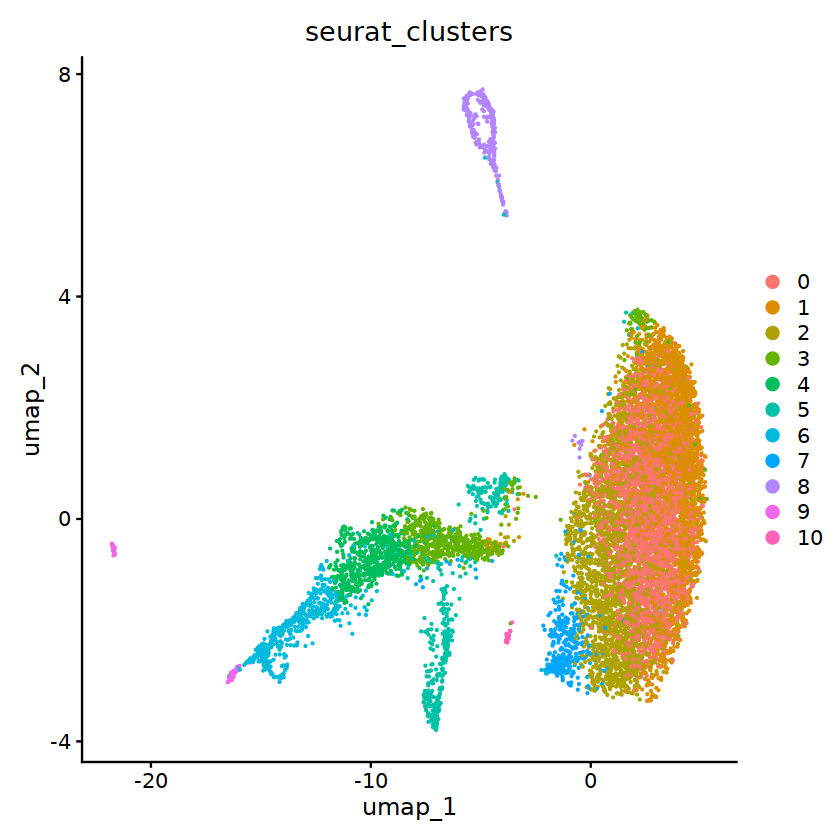

In [ ]:
ifnb = readRDS("hc_rbd_pd_joint_integrated.rds")
ifnb_testct <- subset(ifnb, subset = celltype == "microglia")
set.seed(384)
ifnb_testct <- FindNeighbors(ifnb_testct, reduction = "integrated.cca", dims = 1:30)
ifnb_testct <- FindClusters(ifnb_testct, resolution = 0.5)
ifnb_testct <- RunUMAP(ifnb_testct, dims = 1:30, reduction = "integrated.cca")
DimPlot(ifnb_testct, reduction = "umap", group.by = c("seurat_clusters"))

In [3]:
ifnb_testct <- subset(ifnb_testct, subset = seurat_clusters %in% c(0))

# Export data for monocle

In [ ]:
counts <- GetAssayData(ifnb_testct, assay = "RNA", slot = "counts")
# head(counts)
# Save counts matrix
saveRDS(counts, file = "../../data/c0_counts_v5.rds")

In [ ]:
# Extract metadata
meta_data <- ifnb_testct@meta.data
# Save metadata
saveRDS(meta_data, file = "../../data/c0_metadata_v5.rds")

# UMAP of MG0 colored by disease

In [ ]:
# Define the custom color palette
disease_palette <- c("HC" = "#E15759", "PD" = "#59A14F", "RBD" = "#4E79A7")

# Save the plot as a PDF
pdf("../../man_figs_pdf/mic_umap_disease_MG0.pdf", width = 8, height = 8)
DimPlot(ifnb_testct, 
        reduction = "umap", 
        group.by = "disease", 
        cols = disease_palette, 
        alpha = 0.5, 
        pt.size = 1.5)
# Close the PDF device
dev.off()

pdf 
  2

# Compare DEGs between disease status for MG0

In [5]:
get_degs <- function(ifnb_testct, ident1, ident2, cluster){
    set.seed(384)
    # Set cluster as the main identity
    Idents(ifnb_testct) <- "seurat_clusters"
    
    # Initialize a list to store DEG results for each cluster
    deg_results_by_cluster <- NA
    
    # Subset the Seurat object to only include cells from the current cluster
    cluster_subset <- subset(ifnb_testct, idents = cluster)
  
    # Set disease as the identity for this subset
    Idents(cluster_subset) <- "disease"
  
    # Check if both "PD" and "HC" are present in the subset
    if (all(c(ident1, ident2) %in% unique(Idents(cluster_subset)))) {
      # Perform differential expression analysis between "PD" and "HC" within this cluster
      deg_results <- FindMarkers(cluster_subset, ident.1 = ident1, ident.2 = ident2)
    
      # Store the results in the list, using the cluster as the name
      deg_results_by_cluster <- deg_results
    } else {
      # If one of the groups is missing, print a message and skip the cluster
      message(paste("Skipping cluster", cluster, "- does not contain both disease status cells"))
    }
    return (deg_results_by_cluster)
}


In [6]:
degs_pd_hc <- get_degs(ifnb_testct, "PD", "HC", 0)
degs_rbd_hc <- get_degs(ifnb_testct, "RBD", "HC", 0)
degs_pd_rbd <- get_degs(ifnb_testct, "PD", "RBD", 0)

In [7]:
degs_pd_hc <- degs_pd_hc %>% filter(p_val_adj < 0.05)
degs_rbd_hc <- degs_rbd_hc %>% filter(p_val_adj < 0.05)
degs_pd_rbd <- degs_pd_rbd %>% filter(p_val_adj < 0.05)

In [41]:
degs_pd_hc

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MALAT1,7.225861e-56,-0.3281136,1.000,1.000,2.644737e-51
XIST,3.164694e-40,-1.4091072,0.248,0.518,1.158310e-35
F13A1,3.374431e-31,3.0054084,0.151,0.028,1.235076e-26
HSPA1A,5.866158e-31,-1.4297470,0.211,0.433,2.147073e-26
UTY,1.435122e-29,1.0683481,0.410,0.191,5.252689e-25
LINC00278,2.184820e-27,1.2376196,0.317,0.132,7.996661e-23
NLGN4Y,3.665132e-27,1.6382467,0.233,0.080,1.341475e-22
KCNQ3,1.552041e-24,0.4917918,0.906,0.790,5.680627e-20
HSPA1B,2.421023e-24,-1.5482160,0.118,0.298,8.861187e-20


In [ ]:
library(VennDiagram)
pdf("../../man_figs_pdf/mic_MG0_DEG_Venn.pdf", width = 8, height = 8)
venn.plot <- venn.diagram(
  x = list(
    "PD vs HC" = rownames(degs_pd_hc),
    "RBD vs HC" = rownames(degs_rbd_hc),
    "PD vs RBD" = rownames(degs_pd_rbd)
  ),
  category.names = c("PD vs HC", "RBD vs HC", "PD vs RBD"),
  filename = NULL
)

grid.draw(venn.plot)
dev.off()

pdf 
  2

Loading required package: grid

Loading required package: futile.logger



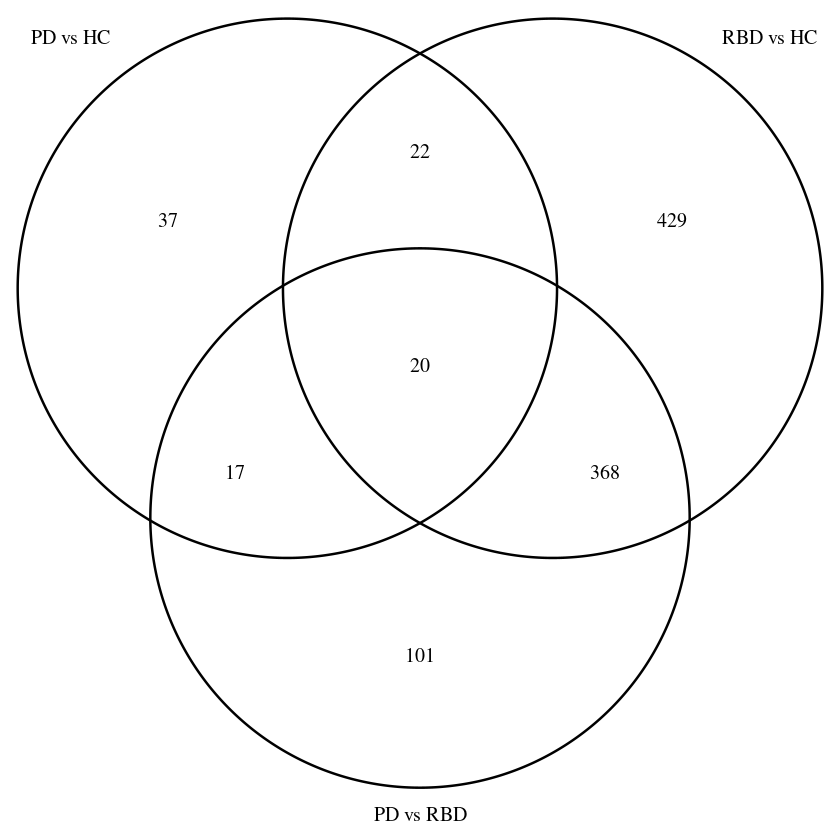

In [24]:
library(VennDiagram)

venn.plot <- venn.diagram(
  x = list(
    "PD vs HC" = rownames(degs_pd_hc),
    "RBD vs HC" = rownames(degs_rbd_hc),
    "PD vs RBD" = rownames(degs_pd_rbd)
  ),
  category.names = c("PD vs HC", "RBD vs HC", "PD vs RBD"),
  filename = NULL
)

grid.draw(venn.plot)

- A lot of genes shared between (RBD vs HC) and (PD vs RBD)
- RBD may serve as an intermediate stage between HC and PD, with a set of genes gradually shifting expression along this trajectory
- RBD different than PD and HC in inflammation microglia 